In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [30]:
models_results = pd.read_csv('../Data/models_results.csv')

In [3]:
models_results.columns

Index(['Model', 'CV_MSE', 'CV_RMSE', 'CV_R2', 'MSE_train', 'RMSE_train',
       'MSE_test', 'RMSE_test', 'R2_train', 'R2_test'],
      dtype='object')

In [4]:
maximize = ['CV_R2', 'R2_train', 'R2_test']
minimize = [x for x in models_results.columns[1:] if x not in maximize]

In [37]:
def highlight_value(s):
    if s.name in maximize:
        mask = s == s.max()
    elif s.name in minimize:
        mask = s == s.min()
    else:
        mask = s.isna()
    return ['background-color: yellow' if v else '' for v in mask]

In [38]:
highlighted_models_results = models_results.copy()
highlighted_models_results.style.apply(highlight_value)

,Model,CV_MSE,CV_RMSE,CV_R2,MSE_train,RMSE_train,MSE_test,RMSE_test,R2_train,R2_test
0,Baseline,nan,nan,nan,8593944992.245739,92703.532793,8607588916.739229,92777.092629,0.000000,0.000000
1,LinearRegression+Data_lr+StandardScaler,3639278072.264776,60326.429301,0.576941,3429409551.327261,58561.160775,4250756476.458890,65197.825703,0.600950,0.506162
2,LinearRegression+Data_lr+MinMaxScaler,3641515217.369488,60344.968451,0.576679,3430432126.609660,58569.890956,4238982720.827599,65107.470545,0.600832,0.507530
3,LinearRegression+Data_lr+RobustScaler,3639464238.104510,60327.972269,0.576915,3429926339.002779,58565.572984,4239003314.138617,65107.628694,0.600890,0.507527
4,LinearRegression+Data_lr+None,3640170929.742506,60333.829066,0.576834,3429307697.827183,58560.291135,4238062531.088125,65100.403463,0.600962,0.507637
5,LinearRegression+Data+StandardScaler,3640275923.925242,60334.699170,0.576822,3430676286.373981,58571.975264,4239122583.192366,65108.544625,0.600803,0.507513
6,LinearRegression+Data+MinMaxScaler,3641298630.919502,60343.173855,0.576703,3430780662.790205,58572.866267,4247853703.425696,65175.560630,0.600791,0.506499
7,LinearRegression+Data+RobustScaler,3639204567.702811,60325.820075,0.576944,3429926339.002779,58565.572984,4239003314.138632,65107.628694,0.600890,0.507527
8,LinearRegression+Data+None,3639810299.965523,60330.840372,0.576875,3429517096.711166,58562.078999,4238075303.042055,65100.501558,0.600938,0.507635
9,LinearRegression+Data_p2+StandardScaler,3080144834.044545,55499.052551,0.642240,2669494984.941751,51667.155766,3577983832.263581,59816.250570,0.689375,0.584322


Как видно, Catboost показывает наилучшие результаты, хотя модель все еще несколько переобучена.

In [39]:
train_data_ne = pd.read_csv('../Data/train_data_with_feats.csv')
test_data_ne = pd.read_csv('../Data/test_data_with_feats.csv')

In [40]:
def cat_feats_encode(df, cat_feats):
    result = df.copy()
    for cat in cat_feats:
        result[cat] = result[cat].replace({'A': 0, 'B': 1})
    return result

In [41]:
cat_feats = ['Ecology_2', 'Ecology_3', 'Shops_2']
train_data = cat_feats_encode(train_data_ne, cat_feats)
test_data = cat_feats_encode(test_data_ne, cat_feats)
y_train = train_data['Price']
y_test = test_data['Price']
X_train = train_data.drop(['DistrictId', 'Price'], axis=1)
X_test = test_data.drop(['DistrictId', 'Price'], axis=1)

In [47]:
X_for_CV = pd.concat([X_train, X_test]).reset_index(drop=True)
y_for_CV = pd.concat([y_train, y_test]).reset_index(drop=True)

In [49]:
from sklearn.model_selection import KFold
from sklearn.base import clone

In [178]:
def regression_CV(estimator, X, y, cv=3, return_train_score=False, return_r2_score=False, return_estimator=False,
                                return_single_mse=False):
    if isinstance(X, pd.core.frame.DataFrame):
        X = X.values
    if isinstance(y, pd.core.frame.DataFrame):
        y = y.values
    results = {}
    results['mse_test'] = []
    if return_r2_score:
        results['r2_test'] = []
        if return_train_score:
            results['r2_train'] = []
    if return_train_score:
        results['mse_train'] = []
    if return_estimator:
        results['estimator'] = []
    if return_single_mse:
        results['single_mse'] = []
    k_fold = KFold(cv)
    for fold, (train, test) in enumerate(k_fold.split(X, y)):
        model = clone(estimator)
        model.fit(X[train], y[train])
        y_pred_train = model.predict(X[train])
        y_pred_test = model.predict(X[test])
        mse_train = mean_squared_error(y[train], y_pred_train)
        mse_test = mean_squared_error(y[test], y_pred_test)
        results['mse_test'].append(mse_test)
        
        if return_estimator:
            results['estimator'].append(model)
            
        if return_r2_score:
            results['r2_test'].append(r2_score(y[test], y_pred_test))
            if return_train_score:
                results['r2_train'].append(r2_score(y[train], y_pred_train))
    
        if return_train_score:
            results['mse_train'].append(mse_train)
        
        if return_single_mse:
            train_mse_singles = []
            test_mse_singles = []
            for n, k in zip(train, range(len(y_pred_train))):
                mse_ = mean_squared_error([y[n]], [y_pred_train[k]])
                train_mse_singles.append((n, mse_))
            for n, k in zip(test, range(len(y_pred_test))):
                mse_ = mean_squared_error([y[n]], [y_pred_test[k]])
                test_mse_singles.append((n, mse_))
                    
            train_mse_singles = pd.DataFrame(train_mse_singles, columns=['index_train_fold_'+str(fold), 'mse_train_fold_'+str(fold)])
            test_mse_singles = pd.DataFrame(test_mse_singles, columns=['index_test_fold_'+str(fold), 'mse_test_fold_'+str(fold)])
            results['single_mse'].append({'fold': fold, 'train_mse_singles': train_mse_singles, 'test_mse_singles': test_mse_singles})
            
    return results

In [179]:
model = CatBoostRegressor(silent=True)

In [180]:
%%time
results_cv = regression_CV(model, X_for_CV, y_for_CV, return_train_score=True, return_r2_score=True, return_estimator=True, return_single_mse=True)

Wall time: 18.7 s


In [204]:
def find_outliers(results_cv):
    result = results_cv.copy()
    for fold in results_cv['single_mse']:
        df_train = fold['train_mse_singles']
        df_test = fold['test_mse_singles']
        for data in [df_train, df_test]:
            out = 3*data[data.columns[1]].std()
            data['outliers'] = data[data.columns[1]].apply(lambda x: 'out' if x > out else 'in')
    
    return result

In [205]:
results_cv = find_outliers(results_cv)

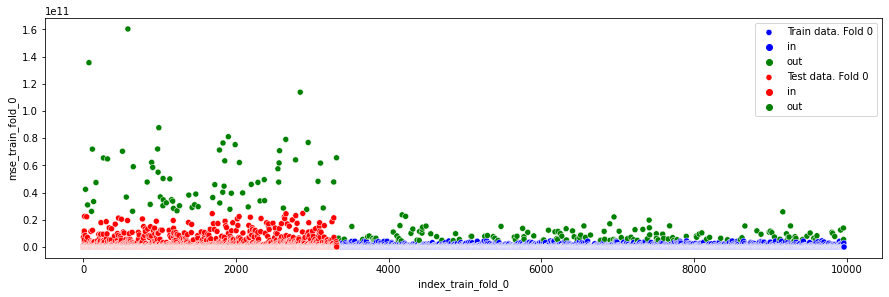

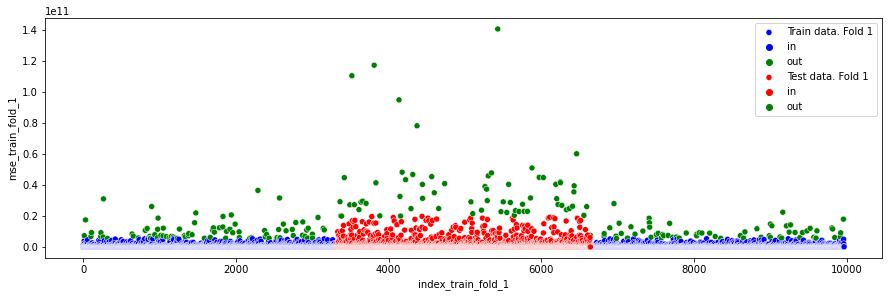

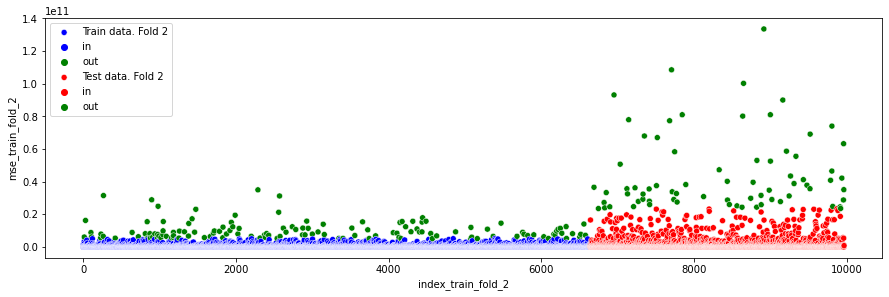

In [207]:
def plot_mse(results_cv, highlight_outliers=False):
    result = results_cv.copy()
    plots = len(result['mse_train'])
    if highlight_outliers:
        result = find_outliers(result)
    for n, fold in enumerate(result['single_mse']):
        df_train = fold['train_mse_singles']
        df_test = fold['test_mse_singles']        
        plt.figure(figsize=(15,15))
        plt.subplot(plots, 1, n+1)
        sns.scatterplot(data=df_train, x=df_train.columns[0], y=df_train.columns[1], 
                        hue=df_train['outliers'] if highlight_outliers else None,
                        label='Train data. Fold '+str(fold['fold']), palette=['blue', 'green'])
        sns.scatterplot(data=df_test, x=df_test.columns[0], y=df_test.columns[1], 
                        hue=df_test['outliers'] if highlight_outliers else None,
                        label='Test data. Fold '+str(fold['fold']), palette=['red', 'green'])
        plt.legend()
        
plot_mse(results_cv, True)

In [218]:
out_index = []
for fold in results_cv['single_mse']:
    df_train = fold['train_mse_singles']
    df_test = fold['test_mse_singles']
    out_index.extend(df_train[df_train.columns[0]].loc[df_train['outliers'] == 'out'])
    out_index.extend(df_test[df_test.columns[0]].loc[df_test['outliers'] == 'out'])
    
out_index = np.unique(out_index)

In [219]:
len(out_index)

364

In [221]:
columns = pd.read_csv('../Data/train.csv').columns

In [223]:
data = pd.concat([X_for_CV, y_for_CV], axis=1)

In [233]:
out_df = data.iloc[out_index][[x for x in data.columns.tolist() if x in columns.tolist()]]

In [235]:
pd.options.display.max_rows = len(out_index)
out_df.sort_values(by='Square', ascending=False)

,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
168,4.0,200.334539,25.0,1.0,2.0,2013,4.111635e-02,1,1,53,4,1,4,1,528560.506016
4733,3.0,190.857689,19.0,7.0,7.0,2007,0.000000e+00,1,1,23,4,2,6,1,338644.075979
9802,5.0,183.382273,15.0,2.0,6.0,1997,9.079910e-02,1,1,74,2,5,15,1,622888.825328
2550,1.0,174.649522,15.0,10.0,12.0,1958,2.361085e-01,1,1,16,27,3,10,1,232766.187698
515,3.0,156.636577,1.0,1.0,3.0,2005,7.215758e-02,1,1,2,1,0,0,0,502523.573863
3550,3.0,138.980817,43.0,2.0,2.0,1977,4.378852e-01,1,1,23,3,0,5,1,169528.896664
76,3.0,129.998756,11.0,21.0,22.0,2012,2.386171e-01,1,1,26,6,3,6,1,132176.743972
7031,3.0,127.141143,1.0,3.0,3.0,2017,1.116274e-01,1,1,50,8,2,3,1,611250.912034
2842,3.0,126.621358,12.0,22.0,48.0,2011,1.116274e-01,1,1,50,8,2,3,1,179396.521035
1172,3.0,122.803190,17.0,6.0,18.0,2015,3.270180e-01,1,1,12,23,1,0,1,203176.229568


In [236]:
from sklearn.model_selection import cross_validate

In [237]:
def model_fit_results(estimator, model_name, data_list, scaler_list, feats_not_to_scale, df_for_results):
    df_res = df_for_results.copy()
    for name, X_train, X_test, y_train, y_test in data_list:
        feats_to_scale = [x for x in X_train.columns if x not in feats_not_to_scale]
        for sc in scaler_list:
            if not isinstance(sc, str):
                scaler = clone(sc)              
                X_train_scaled = np.hstack((scaler.fit_transform(X_train[feats_to_scale]), X_train.drop(feats_to_scale, axis=1).values))
                X_test_scaled = np.hstack((scaler.transform(X_test[feats_to_scale]), X_test.drop(feats_to_scale, axis=1).values))
                scaler_name = scaler.__str__()[:-2]
            elif sc == 'None':
                X_train_scaled = X_train
                X_test_scaled = X_test
                scaler_name = sc
            model = clone(estimator)
            model_cv_results = cross_validate(model, X_train_scaled, y_train, cv=3, scoring=['r2', 'neg_mean_squared_error'])
            model.fit(X_train_scaled, y_train)
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)
            model_mse_train = mean_squared_error(y_train, y_pred_train)
            model_mse_test = mean_squared_error(y_test, y_pred_test)
            r2_train = r2_score(y_train, y_pred_train)
            r2_test = r2_score(y_test, y_pred_test)
            model_results = pd.DataFrame({'Model': [model_name + '+' + name + '+' + scaler_name], 'CV_MSE': [abs(model_cv_results['test_neg_mean_squared_error'].mean())], 
                                  'CV_RMSE': [abs(model_cv_results['test_neg_mean_squared_error'].mean())**0.5], 
                                  'CV_R2': [model_cv_results['test_r2'].mean()], 'MSE_train': [model_mse_train], 
                                  'RMSE_train': [model_mse_train**0.5], 
                                  'MSE_test': [model_mse_test], 'RMSE_test': [model_mse_test**0.5], 'R2_train': [r2_train], 
                              'R2_test': [r2_test]})
            df_res = pd.concat([df_res, model_results], axis=0)
    
    return df_res

In [238]:
X = data.drop('Price', axis=1).drop(out_index, axis=0)
y = data['Price'].drop(out_index, axis=0)

In [240]:
from sklearn.model_selection import train_test_split

In [248]:
data_list = [('Data', *train_test_split(X, y, test_size=0.3, random_state=42))]

In [251]:
results_without_outliers = model_fit_results(model, 'CatBoostRegressor', data_list, scaler_list=['None'], feats_not_to_scale=[], df_for_results=pd.DataFrame({}))

In [252]:
results_without_outliers

,Model,CV_MSE,CV_RMSE,CV_R2,MSE_train,RMSE_train,MSE_test,RMSE_test,R2_train,R2_test
0,CatBoostRegressor+Data+None,1.031500e+09,32116.975298,0.866296,2.943172e+08,17155.676244,8.663999e+08,29434.671387,0.96189,0.88748
